Reproducing MEG Spectrum:
---
This notebook shows how to reproduce MEG spectrums as shown in Figure 3 of the manuscript. We will use `freqMEGdata_8002-101.h5`, anonymous subject 8002-101's source localized MEG recording that is downsampled and filtered as an example.

In [1]:
# this path append is for binder only
import os
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.forward import runforward
from spectrome.utils import functions, path
from spectrome.brain import Brain

#generic modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import lfilter, firls, decimate

In [2]:
# Set up some frequency bins and filters
fs = 600 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 100])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)
ind_del = hbp.size #number of coefficients in hbp. Delete that number in beginning of signal due to filtering

Let's load the source localized MEG spectrum first:

In [3]:
data_path = path.get_data_path()
MEG_path = os.path.join(data_path, 'freqMEGdata_8002-101.h5')
FMEGdata = path.read_hdf5(MEG_path)
# all the regions with MEG:
FMEGdata.keys()

dict_keys(['LHbankssts', 'LHcaudalanteriorcingulate', 'LHcaudalmiddlefrontal', 'LHcuneus', 'LHentorhinal', 'LHfrontalpole', 'LHfusiform', 'LHinferiorparietal', 'LHinferiortemporal', 'LHinsula', 'LHisthmuscingulate', 'LHlateraloccipital', 'LHlateralorbitofrontal', 'LHlingual', 'LHmedialorbitofrontal', 'LHmiddletemporal', 'LHparacentral', 'LHparahippocampal', 'LHparsopercularis', 'LHparsorbitalis', 'LHparstriangularis', 'LHpericalcarine', 'LHpostcentral', 'LHposteriorcingulate', 'LHprecentral', 'LHprecuneus', 'LHrostralanteriorcingulate', 'LHrostralmiddlefrontal', 'LHsuperiorfrontal', 'LHsuperiorparietal', 'LHsuperiortemporal', 'LHsupramarginal', 'LHtemporalpole', 'LHtransversetemporal', 'RHbankssts', 'RHcaudalanteriorcingulate', 'RHcaudalmiddlefrontal', 'RHcuneus', 'RHentorhinal', 'RHfrontalpole', 'RHfusiform', 'RHinferiorparietal', 'RHinferiortemporal', 'RHinsula', 'RHisthmuscingulate', 'RHlateraloccipital', 'RHlateralorbitofrontal', 'RHlingual', 'RHmedialorbitofrontal', 'RHmiddletempo

In [4]:
MEG_df = pd.DataFrame(FMEGdata)
MEG = MEG_df.values #40 frequency bins x  68 regions
print(MEG.shape) # 68 regions because we only did source localization to cortical regions for high SNR

(40, 68)


Load optimized parameters for the same subject and simulate its frequency spectrum:

In [5]:
from scipy.io import loadmat

brain = Brain.Brain()
brain.add_connectome(data_path)
## re-ordering for DK atlas and normalizing the connectomes:
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

## Load optimized parameters:
opparam = loadmat(data_path + '/SCFC_opparam_individual.mat') # *_individual.mat is parameters optimized with individual connectome
# opparam = loadmat(data_path + '/SCFC_opparam_HCP.mat') # replace with this if you want to look like parameters with hcp connectome
param_df = pd.DataFrame(opparam['output'][:,0])
params = param_df.loc[0,'param']

## Reassign back into brain:
brain.ntf_params['tau_e'] = params[0]
brain.ntf_params['tau_i'] = params[1]
brain.ntf_params['alpha'] = params[2]
brain.ntf_params['speed'] = params[3]
brain.ntf_params['gei'] = params[4]
brain.ntf_params['gii'] = params[5]
brain.ntf_params['tauC'] = params[6]
print(brain.ntf_params)

model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_local_coupling_forward(brain, brain.ntf_params, fvec)
print(model_spectrum.shape)

{'tau_e': array([0.00734772]), 'tau_i': array([0.0085479]), 'alpha': array([0.46386488]), 'speed': array([18.30706011]), 'gei': array([2.94693054]), 'gii': array([4.48646242]), 'tauC': array([0.00613412])}
(86, 40)


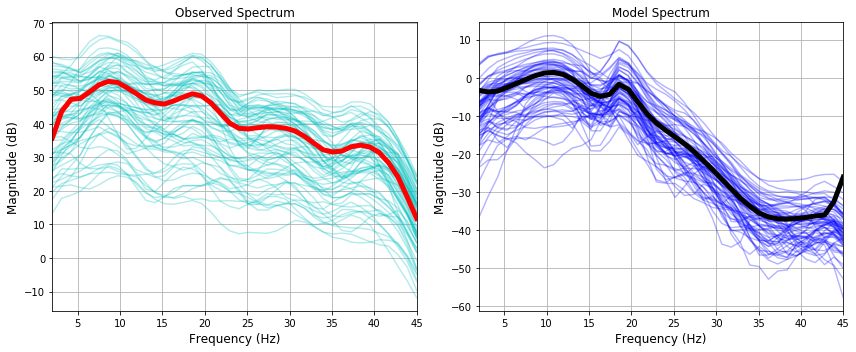

In [6]:
#matplotlib:
fsize = 12
f_meg, (ax_meg, ax_sim) = plt.subplots(1,2, figsize = (12,5))
plt.style.use('seaborn-paper')
for g in range(len(MEG.T)):
    mag_meg = np.convolve(MEG[:,g], lpf, 'same')
    mag_sim = np.convolve(np.abs(model_spectrum[g,:]), lpf, 'same')
    ax_meg.plot(fvec, functions.mag2db(mag_meg), color = 'c', alpha = 0.3)
    ax_sim.plot(fvec, functions.mag2db(mag_sim), color = 'b', alpha = 0.3)

mean_FMEG = functions.mag2db(np.mean(MEG, axis = 1))
ax_meg.plot(fvec, np.convolve(mean_FMEG, lpf, 'same'), color = 'r', linewidth = 5)
ax_meg.grid(True)
ax_meg.set_xlabel('Frequency (Hz)', fontsize = fsize)
ax_meg.set_ylabel('Magnitude (dB)', fontsize = fsize)
ax_meg.autoscale(enable=True, axis='x', tight=True)
ax_meg.set_title('Observed Spectrum', fontsize = fsize)
plt.tight_layout()

mean_Fsim = functions.mag2db(np.mean(np.abs(model_spectrum), axis = 0))
ax_sim.plot(fvec, np.convolve(mean_Fsim, lpf, 'same'), color = 'k', linewidth = 5)
ax_sim.grid(True)
ax_sim.set_xlabel('Frequency (Hz)', fontsize = fsize)
ax_sim.set_ylabel('Magnitude (dB)', fontsize = fsize)
ax_sim.autoscale(enable=True, axis='x', tight=True)
ax_sim.set_title('Model Spectrum', fontsize = fsize)
plt.tight_layout()